![PIC UPV PERTE Chip Chair Logo](https://www.pic-chair.upv.es/wp-content/uploads/2024/05/logo-upv-horizontal.png)
![PIC UPV PERTE Chip Chair Logo](https://www.pic-chair.upv.es/wp-content/uploads/2024/06/logos-perte-chip-1024x119.png)


# Laboratory 3. Interferometers I - MZI


Today we will work on the design and modeling of an **Mach-Zenhder Interferometer (MZI)** used in integrated photonic circuits. We will perform simulations that will allow us to understand how it operates.


## 0.0 Imports
(Run once  - before running other codes)

## 0.1 General libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import tidy3d as td
import logging
import sys
from functools import partial
from pprint import pprint

import gdsfactory as gf
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import sax
from gdsfactory.generic_tech import get_generic_pdk
from scipy import constants
from scipy.constants import c
from scipy.interpolate import interp1d

import gplugins.sax as gs
from gplugins.common.config import PATH

nm = 1e-3
wavelength = np.linspace(1500, 1600) * nm
f = td.C_0 / wavelength

## 1. MZI modeling
Let's compute the transfer function of a MZI

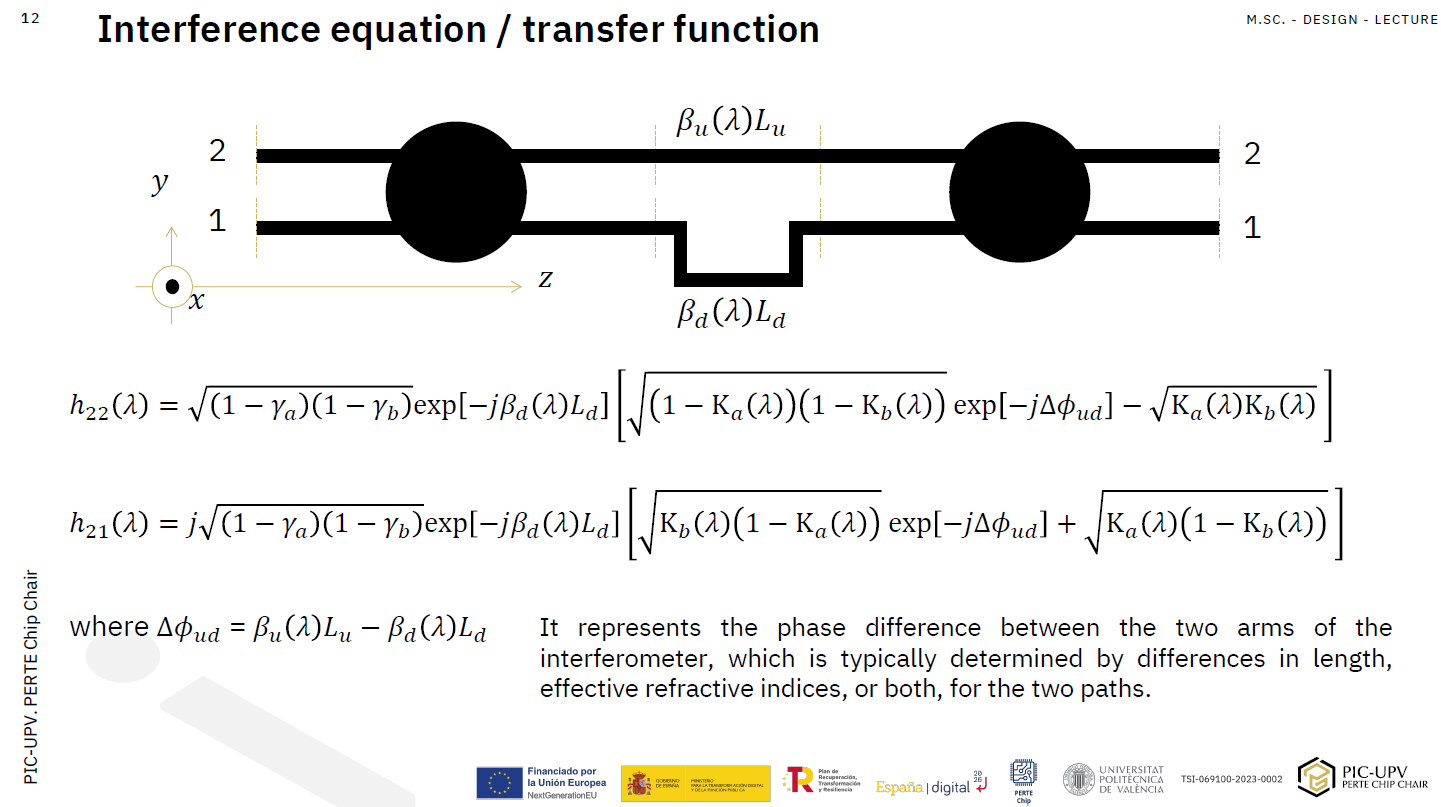

In [ ]:
### Waveguides configuration ###

## Propagation parameters

## SOI cross-section ##
SOI = np.loadtxt('SOI-w450-h220-clad600.txt', skiprows=1, delimiter='\t')

wvl = SOI[:, 0]
neffu = SOI[:, 3] #balanced configuration // (neff TE mode)
neffd = SOI[:, 3] #balanced configuration // (neff TE mode)

## SiN cross-section ##
# SiN_clad = np.loadtxt('SiN-h300nm-w1000nm-Cladding.txt', skiprows=1, delimiter='\t')
# SiN_wat = np.loadtxt('SiN-h300nm-w1000nm-Water.txt', skiprows=1, delimiter='\t')

# wvl0 = SiN_clad[:, 0]
# neffu0 = SiN_clad[:, 3] #balanced configuration // (neff TE mode)
# neffd0 = SiN_wat[:, 3] #balanced configuration // (neff TE mode)

# interp_neffu = interp1d(wvl0, neffu0, kind='cubic')  # Cubic interpolation for smoothness
# interp_neffd = interp1d(wvl0, neffd0, kind='cubic')
# wvl = np.linspace(wvl0.min(), wvl0.max(), 1000)
# neffu = interp_neffu(wvl)
# neffd = interp_neffd(wvl)

# Propagation loss
alphau = 0; #losless case [dB/cm]
alphad = 0; #losless case [dB/cm]
alphau_np =  100 * alphau / (20*jnp.log10(np.exp(1)))
alphad_np =  100 * alphad / (20*jnp.log10(np.exp(1)))

# Path length
Lu = 5; # um
Ld = 5; # um

betau = (2*np.pi/wvl)*neffu-1j*alphau_np/2
betad = (2*np.pi/wvl)*neffd-1j*alphad_np/2

Delta_phi_ud = betau*Lu - betad*Ld

### Couplers configuration ###
# Excess loss
gamma_a = 0; #null excess loss
gamma_b = 0; #null excess loss

# Coupling constant
K_a = np.full(wvl.shape, 0.5)
K_b = np.full(wvl.shape, 0.5)

# MZI transfer function (h22 & h21)

#  h_22(wvl)
h_22 = (np.sqrt((1 - gamma_a) * (1 - gamma_b)))*(np.exp(-1j * betad * Ld))*(( np.sqrt((1 - K_a) * (1 - K_b)) * np.exp(-1j * Delta_phi_ud))-(np.sqrt(K_a * K_b)))

#  h_21(wvl)
h_21 = (1j * np.sqrt((1 - gamma_a) * (1 - gamma_b)))*(np.exp(-1j * betad * Ld))*((np.sqrt(K_b * (1 - K_a)) * np.exp(-1j * Delta_phi_ud))+(np.sqrt(K_a * (1 - K_b))))

H21 = np.abs(h_21) ** 2
H22 = np.abs(h_22) ** 2

H21dB = 10*np.log10(H21)
H22dB = 10*np.log10(H22)


# Plot
color = cm.rainbow(np.linspace(0, 1, 10))

plt.plot(wvl, H22, linestyle='-', color=color[1], label='H22')
plt.plot(wvl, H21, linestyle='--', color=color[1], label='H21')
plt.xlabel('Wvl (um)')
plt.ylabel('|H|^2 [lin]')
plt.title('MZI Transfer function')
plt.legend()
plt.grid(True)

plt.show()

plt.plot(wvl, H22dB, linestyle='-', color=color[1], label='H22')
plt.plot(wvl, H21dB, linestyle='--', color=color[1], label='H21')
plt.xlabel('Wvl (um)')
plt.ylabel('|H|^2 [dB]')
plt.title('MZI Transfer function')
plt.legend()
plt.grid(True)

plt.show()

**Assesment 1.** Please, provide one example of each one of the configurations studied during MZI lecture:
1. Balenced configuration
2. Unbalanced configuration
  1.   Phase difference
  2.   Delay imbalance

**Assesment 2.** Taking into account the n_{eff} values for the SOI cross-section, what would be the path difference ($\Delta L$ = $L_u$ - $L_d$) needed to obtain a Free Spectral Range of 40 nm? Introduce the obtained value in the model to check the MZI response. Hint: We assume 1550 nm as the central design wavelength ($\lambda _0$=1550 nm).

## 2. MZI simulation implemented with SAX
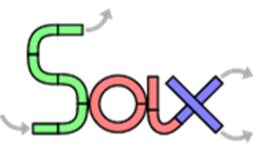

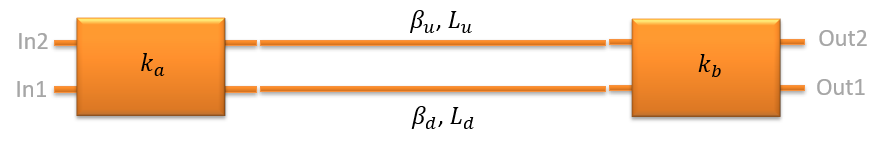


### 2.1 Components S matrix


In [ ]:
# Waveguide Model

def waveguide(wl=1.55, neff=1.6072, length=10.0, loss=0.0) -> sax.SDict:
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase) # loss(dB/cm)
    wg_dict = sax.reciprocal(
        {
            ("in0", "out0"): transmission,
        }
    )
    return wg_dict


# Coupler Model

def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling**0.5
    tau = (1 - coupling) ** 0.5
    coupler_dict = sax.reciprocal(
        {
            ("in0", "out0"): tau,
            ("in0", "out1"): kappa * np.exp(-1j * np.pi / 2.0),
            ("in1", "out0"): kappa * np.exp(-1j * np.pi / 2.0),
            ("in1", "out1"): tau,
        }
    )
    return coupler_dict

### 2.2 MZI SAX Circuit Model

In [ ]:
# MZI

mzi, info = sax.circuit(
    netlist={
        "instances": {
            "coup_a": "coupler",
            "wvg_u": "waveguide",
            "wvg_d": "waveguide",
            "coup_b": "coupler",
        },
        "connections": {
            "coup_a,out0": "wvg_d,in0",
            "wvg_d,out0": "coup_b,in0",
            "coup_a,out1": "wvg_u,in0",
            "wvg_u,out0": "coup_b,in1",
        },
        "ports": {
            "in0": "coup_a,in0",
            "in1": "coup_a,in1",
            "out0": "coup_b,out0",
            "out1": "coup_b,out1",
        },
    },
    models={
        "coupler": coupler,
        "waveguide": waveguide,
    },
)


### 2.3. MZI Modeling
**Assesment 3**: Now, we are going to implement the design parameters in the MZI model developed in SAX and compare the response obtained with that simulated by mathematical formulation.

This will help us to identify any error in the definition of the SAX model single components.

In order to implement the SAX model, take as example the following lines:

    mzi_test = mzi(wl=wl,
    coup_a = ...
    wvg_d={"length": l_d, "neff": ...},
    wvg_u={"length": l_u, "neff": ...},
    coup_b = ... )

    H00 = mzi_test["in0", "out0"]

**EXTRA ASSESSMENTS**

**Assessment 4.** Designing an MZI for filtering at a specific wavelength. Calculate and adjust the arm lengths to configure the MZI to have a maximum transmission at 1550 nm.

**Assessment 5.** Let's see how the response of the MZI variates with the effective index. Vary the effective index of one of the arms and analyze how the spectrum shifts. To do this, you can use the data provided in the .txt files entitled ‘SiN’.
Can you give an example of an application where this configuration is used?

**Advanced level assessment.** Explore how cascading two MZIs affects the transmission spectrum. To do so, design a system in which two MZIs are cascaded. Simulate and observe the spectrum, explaining how the transmission peaks behave.